## Steps involved for application of CP decomposition
1. Get pretrained ALEXNET from torch
2. Get the first layer weights in ALEXNET
3. Compute the 4-way CP decomposition over those weights
4. Cross check the output

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pytest
import torch
from lib.CP_4_Way_Decomposition import four_Way_CP_Decomposition, reconstruct_Four_Way_Tensor

In [5]:
def load_Image(image_path):
    '''
    This function reads the image and converts it into a tensor
    Input:
    image_path : Path of the image
    Output:
    image_torch_tensor : A tensor containing the input image
    '''
    print("Loading the image...")
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.show()
    np_image = np.asarray(image)
    np_image = np_image.astype(np.float32)
    image_torch_tensor = torch.from_numpy(np_image)
    return image_torch_tensor

def load_ALEXNET(layer):
    '''
    This function loads the ALEXNET and returns a weights of the specified layer
    Input:
    layer : This specifies the required layer weights
    Output:
    first_weight_tensor : Weights of the specified layer
    '''
    print("Loading the ALEXNET")
    alexnet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
    first_weight_tensor = alexnet_model.features[layer].weight.data
    return first_weight_tensor

def compute_CP_Convolution(factors, input_image):
    '''
    This function computes the convolution output using the factors from the CP decomposition
    Input:
    factors : factors for the weights from the layer from the ALEXNET
    input_image : Tensor containing the values for the input
    Output:
    V_xyt : The output image from the convolution
    '''
    K_t = factors[0]
    K_s = factors[1]
    K_y = factors[2]
    K_x = factors[3]
    print("Computing the convolution using CP decomposition factors")
    U_s = torch.nn.functional.conv2d(input_image.T.unsqueeze(0), K_s.T.unsqueeze(-1).unsqueeze(-1)).squeeze(0)
    U_sy = torch.nn.functional.conv2d(U_s.unsqueeze(1), K_y.T.unsqueeze(1).unsqueeze(1))
    U_syx = torch.nn.functional.conv2d(U_sy, K_x.T.unsqueeze(0).unsqueeze(-1)).squeeze(1).unsqueeze(0)
    V_xyt = torch.nn.functional.conv2d(U_syx, K_t.unsqueeze(-1).unsqueeze(-1))
    return V_xyt

def compute_Convolution(weights, input_image):
    '''
    This function computes the direct convolution from the weights of the specified layer with input image
    Input:
    weights : weights from the layer from the ALEXNET
    input_image : Tensor containing the values for the input
    Output:
    output : The output image from the convolution
    '''
    print("Computing the convolution using direct multiplication of weights to the image")
    output = torch.nn.functional.conv2d(input_image.T.unsqueeze(0), weights)
    return output

def pytest_output(output_1, output_2):
    '''
    This function asserts wether the output one is equal to another output
    Input:
    output_1 : This variable contains the output from the convolution calculated from CP_Decomposition
    output_2 : This variable contains the output from the convolution calculated from direct convolution
    Output:
    '''
    op1 = output_1.detach().numpy()
    op2 = output_2.detach().numpy()
    assert (op1 == op2).all()
    print("Passed")

## Parameters

In [6]:
max_iter = 20000
l_rate = 0.05
rank = 4
r_state = 0

## Factors using the implemented CP decomposition

Loading the image...


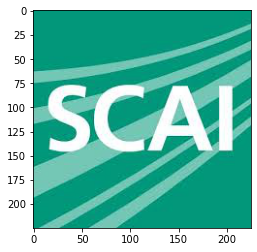

torch.Size([225, 225, 3])
Loading the ALEXNET


Using cache found in /home/lveeramacheneni/.cache/torch/hub/pytorch_vision_v0.6.0


Computing the convolution using CP decomposition factors
Computing the convolution using direct multiplication of weights to the image


In [7]:
path = "scai_image.jpg"
image_torch_tensor = load_Image(path)
print(image_torch_tensor.shape)
weights = load_ALEXNET(0)
outputs_CP = four_Way_CP_Decomposition(weights, rank, max_iter, l_rate, r_state)
V = compute_CP_Convolution(outputs_CP[1], image_torch_tensor)
original_op = compute_Convolution(weights, image_torch_tensor)

In [8]:
print(V.shape)
print(original_op.shape)

torch.Size([1, 64, 215, 215])
torch.Size([1, 64, 215, 215])


In [9]:
pytest_output(V.squeeze(0), original_op.squeeze(0))

AssertionError: 

In [10]:
print(V.squeeze(0)[0, :, :])

tensor([[ -28.7711,  -28.7711,  -28.7711,  ...,  -21.1720,  -33.2680,
          -67.5978],
        [ -28.7711,  -28.7711,  -28.7711,  ...,  -43.1137,  -65.7358,
         -112.6760],
        [ -28.7711,  -28.7711,  -28.7711,  ...,  -68.6533, -104.3887,
         -162.6713],
        ...,
        [ -39.2260,  -41.8596,  -46.2426,  ...,  -28.7711,  -28.7711,
          -28.7711],
        [ -40.1214,  -42.2703,  -47.2151,  ...,  -28.7711,  -28.7711,
          -28.7711],
        [ -39.4981,  -39.8059,  -44.6491,  ...,  -28.7711,  -28.7711,
          -28.7711]], grad_fn=<SliceBackward>)


In [11]:
diff_1 = V.squeeze(0)-original_op.squeeze(0)
np.set_printoptions(suppress=True)
print(diff_1.detach().numpy())

[[[ -10.60738     -10.60738     -10.60738    ...   15.858566
     19.689148     20.60376   ]
  [ -10.60738     -10.60738     -10.60738    ...   22.569279
     20.368279      7.2909164 ]
  [ -10.60738     -10.60738     -10.60738    ...   34.657646
     22.587494     -7.7040405 ]
  ...
  [  -0.40068436    4.4772415    10.183483   ...  -10.60738
    -10.60738     -10.60738   ]
  [   2.3434525     7.229286      9.913975   ...  -10.60738
    -10.60738     -10.60738   ]
  [   1.3855133     5.039253      3.6912231  ...  -10.60738
    -10.60738     -10.60738   ]]

 [[ 409.03452     409.03452     409.03452    ...  399.1742
    389.3329      368.59506   ]
  [ 409.03452     409.03452     409.03452    ...  386.21075
    378.19135     353.396     ]
  [ 409.03452     409.03452     409.03452    ...  372.2658
    364.44153     337.00473   ]
  ...
  [ 409.45224     403.2905      396.91397    ...  409.03452
    409.03452     409.03452   ]
  [ 412.21918     403.46414     391.94516    ...  409.03452
    4

## Factors using the tensorly

In [12]:
from tensorly.decomposition import parafac
import tensorly

In [13]:
ops = parafac(tensorly.tensor(weights), rank, max_iter)[1]
ops_tensor = []
for i in ops:
    ops_tensor.append(torch.from_numpy(i))
V_tensorly = compute_CP_Convolution(ops_tensor, image_torch_tensor)

Computing the convolution using CP decomposition factors


In [14]:
print(V_tensorly.shape)
print(original_op.shape)

torch.Size([1, 64, 215, 215])
torch.Size([1, 64, 215, 215])


In [15]:
pytest_output(V_tensorly.squeeze(0), original_op.squeeze(0))

AssertionError: 

In [16]:
print(V_tensorly.squeeze(0)[0, :, :])

tensor([[-307.5905, -307.5905, -307.5905,  ..., -300.5614, -321.0105,
         -386.2018],
        [-307.5905, -307.5905, -307.5905,  ..., -344.9921, -383.7352,
         -484.7032],
        [-307.5905, -307.5905, -307.5905,  ..., -396.9563, -459.2193,
         -598.5754],
        ...,
        [-340.4780, -345.2704, -356.7423,  ..., -307.5905, -307.5905,
         -307.5905],
        [-345.2287, -348.4759, -360.4012,  ..., -307.5905, -307.5905,
         -307.5905],
        [-349.0113, -350.1138, -358.9842,  ..., -307.5905, -307.5905,
         -307.5905]])


In [17]:
diff_2 = V_tensorly.squeeze(0)-original_op.squeeze(0)
print(diff_2)

tensor([[[-289.4268, -289.4268, -289.4268,  ..., -263.5309, -268.0533,
          -298.0002],
         [-289.4268, -289.4268, -289.4268,  ..., -279.3091, -297.6311,
          -364.7362],
         [-289.4268, -289.4268, -289.4268,  ..., -293.6454, -332.2430,
          -443.6082],
         ...,
         [-301.6527, -298.9335, -300.3162,  ..., -289.4268, -289.4268,
          -289.4268],
         [-302.7638, -298.9763, -303.2721,  ..., -289.4268, -289.4268,
          -289.4268],
         [-308.1277, -305.2686, -310.6438,  ..., -289.4268, -289.4268,
          -289.4268]],

        [[ 393.2554,  393.2554,  393.2554,  ...,  380.8914,  370.4489,
           346.0580],
         [ 393.2554,  393.2554,  393.2554,  ...,  366.7840,  357.0621,
           325.0157],
         [ 393.2554,  393.2554,  393.2554,  ...,  350.9783,  340.1505,
           301.3080],
         ...,
         [ 389.7247,  384.0264,  377.2250,  ...,  393.2554,  393.2554,
           393.2554],
         [ 391.6784,  383.4735,  371.517

## original

In [18]:
print(original_op.squeeze(0)[0, :, :])

tensor([[ -18.1637,  -18.1637,  -18.1637,  ...,  -37.0306,  -52.9571,
          -88.2015],
        [ -18.1637,  -18.1637,  -18.1637,  ...,  -65.6830,  -86.1041,
         -119.9669],
        [ -18.1637,  -18.1637,  -18.1637,  ..., -103.3110, -126.9762,
         -154.9673],
        ...,
        [ -38.8253,  -46.3368,  -56.4261,  ...,  -18.1637,  -18.1637,
          -18.1637],
        [ -42.4649,  -49.4996,  -57.1291,  ...,  -18.1637,  -18.1637,
          -18.1637],
        [ -40.8836,  -44.8452,  -48.3404,  ...,  -18.1637,  -18.1637,
          -18.1637]])


## Workspace

In [16]:
ops_new = outputs_CP[1]
recons_1 = reconstruct_Four_Way_Tensor(ops_new[0], ops_new[1], ops_new[2], ops_new[3])

In [17]:
print(recons_1[0, 0, :, :])

tensor([[ 0.0031,  0.0033,  0.0036,  0.0050, -0.0042, -0.0051, -0.0011, -0.0085,
         -0.0081, -0.0039, -0.0024],
        [ 0.0074,  0.0084,  0.0153,  0.0167,  0.0017, -0.0034, -0.0021, -0.0156,
         -0.0166, -0.0110, -0.0074],
        [ 0.0333,  0.0380,  0.0782,  0.0768,  0.0375,  0.0068, -0.0131, -0.0535,
         -0.0616, -0.0503, -0.0308],
        [ 0.0497,  0.0563,  0.1165,  0.1147,  0.0515,  0.0059, -0.0206, -0.0837,
         -0.0951, -0.0764, -0.0475],
        [ 0.0628,  0.0715,  0.1483,  0.1477,  0.0618,  0.0050, -0.0243, -0.1091,
         -0.1234, -0.0973, -0.0622],
        [ 0.0711,  0.0865,  0.1729,  0.1808,  0.0858,  0.0251, -0.0064, -0.1097,
         -0.1298, -0.1010, -0.0675],
        [ 0.0606,  0.0714,  0.1432,  0.1497,  0.0531,  0.0026, -0.0129, -0.1087,
         -0.1226, -0.0910, -0.0617],
        [ 0.0489,  0.0562,  0.1106,  0.1159,  0.0303, -0.0089, -0.0145, -0.0952,
         -0.1043, -0.0747, -0.0504],
        [ 0.0408,  0.0491,  0.0922,  0.0985,  0.0372,  0

In [18]:
recons_2 = reconstruct_Four_Way_Tensor(ops_tensor[0], ops_tensor[1], ops_tensor[2], ops_tensor[3])

In [19]:
print(recons_2[0, 0, :, :])

tensor([[ 0.0047,  0.0049,  0.0293,  0.0527,  0.0660,  0.0545,  0.0314,  0.0214,
          0.0194,  0.0099, -0.0058],
        [ 0.0086,  0.0149,  0.0452,  0.0540,  0.0580,  0.0598,  0.0548,  0.0328,
          0.0070, -0.0036, -0.0075],
        [ 0.0358,  0.0515,  0.1490,  0.1748,  0.1784,  0.1622,  0.1268,  0.0613,
         -0.0015, -0.0274, -0.0323],
        [ 0.0565,  0.0603,  0.1786,  0.2243,  0.2238,  0.1488,  0.0482, -0.0122,
         -0.0297, -0.0475, -0.0531],
        [ 0.0718,  0.0690,  0.1880,  0.2237,  0.2045,  0.0984, -0.0270, -0.0820,
         -0.0743, -0.0787, -0.0661],
        [ 0.0724,  0.0731,  0.1686,  0.1629,  0.1172,  0.0313, -0.0552, -0.1079,
         -0.1146, -0.1067, -0.0626],
        [ 0.0619,  0.0724,  0.1291,  0.0658, -0.0076, -0.0388, -0.0460, -0.0981,
         -0.1448, -0.1273, -0.0468],
        [ 0.0465,  0.0645,  0.0797, -0.0298, -0.1216, -0.1007, -0.0357, -0.0815,
         -0.1589, -0.1339, -0.0279],
        [ 0.0361,  0.0334,  0.0270, -0.0403, -0.1070, -0

In [20]:
print(weights[0, 0, :, :])

tensor([[ 0.1186,  0.0941,  0.0954,  0.1052,  0.1029,  0.0672,  0.0505,  0.0501,
          0.0558,  0.0216,  0.0500],
        [ 0.0749,  0.0389,  0.0530,  0.0760,  0.0723,  0.0729,  0.0520,  0.0271,
          0.0257, -0.0113,  0.0042],
        [ 0.0754,  0.0388,  0.0549,  0.0558,  0.0525,  0.0500,  0.0476,  0.0253,
          0.0436,  0.0102,  0.0133],
        [ 0.0704,  0.0525,  0.0631,  0.0622,  0.0589,  0.0386,  0.0450,  0.0381,
          0.0458,  0.0019,  0.0030],
        [ 0.0873,  0.0750,  0.0716,  0.0834,  0.0946,  0.0654,  0.0335,  0.0210,
          0.0221, -0.0106, -0.0343],
        [ 0.0958,  0.0992,  0.1006,  0.1088,  0.0726,  0.0361, -0.0075, -0.0431,
         -0.0379, -0.0568, -0.0560],
        [ 0.1150,  0.1155,  0.1071,  0.0915,  0.0029, -0.0900, -0.1133, -0.1391,
         -0.1248, -0.0845, -0.0745],
        [ 0.0955,  0.1103,  0.0825,  0.0421, -0.0594, -0.1595, -0.1237, -0.1581,
         -0.1643, -0.1153, -0.0928],
        [ 0.0932,  0.1037,  0.0675,  0.0244, -0.0697, -0

## Gauss newton optimization

In [28]:
def calc_L2_loss(a, b, c, d, op2):
    a = torch.from_numpy(a)
    b = torch.from_numpy(b)
    c = torch.from_numpy(c)
    d = torch.from_numpy(d)
    op2 = op2.detach().numpy()
    op1 = reconstruct_Four_Way_Tensor(a, b, c, d).detach().numpy()
    return np.linalg.norm(op1-op2)

In [30]:
a = np.random.rand(weights.shape[0], 4)
b = np.random.rand(weights.shape[1], 4)
c = np.random.rand(weights.shape[2], 4)
d = np.random.rand(weights.shape[3], 4)
for i in range(0, 1):
    loss_a = calc_L2_loss(a, b, c, d, weights)
    jac = np.gradient(loss_a)

[]
